<center>
<h2><strong>CLASIFICACIÓN DE VINOS</strong></h2>
<p>Autores:<br>
Luna Juárez Armando 319056323<br>
Mata Lugo Daniela 319302149<br>
Pérez Cruz Fernando 422022569</p>
</center>

### ÍNDICE

1. [Comprensión](#s1)
2. [Fundamentos](#s2)
3. [Investigación](#s3)
4. [Código](#s4)
5. [Resultados](#s5)
6. [Conclusiones](#s6)
7. [Pruebas](#s7)
8. [Referencias](#s8)

#### <a id="s1"></a>**COMPRENSIÓN**

En este proyecto se aborda un problema clásico de **clasificación supervisada** (el dataset *Wine* de *scikit-learn*) mediante un enfoque de **aprendizaje automático cuántico**. El modelo principal es un **clasificador cuántico variacional (VQC)**, que combina la representación de datos en un **espacio de Hilbert de dimensión exponencial** con un circuito cuántico parametrizado entrenado mediante optimización clásica. De esta forma, se ponen en práctica conceptos fundamentales de computación cuántica como **superposición**, **entrelazamiento**, **codificación de información en amplitudes** y **algoritmos variacionales híbridos**.

Los datos clásicos se preprocesan (normalización y PCA) hasta obtener un vector de **8 características por muestra**, lo que permite codificarlos en un registro de **3 qubits** (ya que \(2^3 = 8\)). Esta codificación se implementa mediante el mapa de características `RawFeatureVector`, que asigna cada componente del vector de entrada a una **amplitud del estado cuántico**. Así, cada muestra se representa como un estado \(|\psi(x)\rangle\) en superposición de los estados base, respetando la normalización física del sistema. El uso de *amplitude encoding* no es arbitrario: aprovecha que un pequeño número de qubits puede representar un vector en un espacio de dimensión exponencial, lo que potencialmente permite capturar estructuras complejas en los datos con pocos recursos físicos.

Sobre este estado codificado se aplica un circuito variacional basado en `EfficientSU2`. Este *ansatz* introduce **rotaciones parametrizadas** en cada qubit, que controlan la superposición, y **compuertas de entrelazamiento** entre los qubits, generando correlaciones cuánticas que no pueden reproducirse con simples productos de estados independientes. Al repetir estas capas varias veces se obtiene un modelo cuántico **expresivo**, capaz de aproximar fronteras de decisión no lineales en el espacio de características. Los parámetros libres de este *ansatz* se agrupan en un vector \(\theta\) que se ajusta durante el entrenamiento, de forma análoga a los pesos de una red neuronal.

El entrenamiento del VQC sigue el paradigma de los **algoritmos híbridos cuántico–clásicos**, adecuados para la era NISQ. La parte cuántica, implementada con la primitiva `StatevectorSampler`, se encarga de ejecutar el circuito para cada muestra y obtener las **probabilidades de medición** asociadas a cada clase. La parte clásica utiliza estas probabilidades para calcular una **función de pérdida de entropía cruzada multiclase** y actualizar los parámetros \(\theta\) mediante el optimizador `COBYLA`, que no requiere gradientes analíticos y es robusto frente a funciones de costo **no convexas**, típicas de los modelos variacionales. Esta elección refleja una comprensión de las limitaciones actuales del hardware cuántico y de la necesidad de recurrir a esquemas híbridos para entrenar circuitos con profundidad moderada.



#### <a id="s2"></a>**FUNDAMENTOS**

1. Espacio de Hilbert y representación de estados cuánticos

En computación cuántica, el estado de un sistema de qubits se describe matemáticamente en un **espacio de Hilbert**, que es un espacio vectorial complejo con un producto interno bien definido.

Un solo qubit se representa como un vector en un espacio de dimensión 2:

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle,
\quad \alpha, \beta \in \mathbb{C},\quad
|\alpha|^2 + |\beta|^2 = 1
$$

La condición $|\alpha|^2 + |\beta|^2 = 1$ asegura que el estado esté **normalizado** (las probabilidades suman 1).

Para $n$ qubits, el espacio de Hilbert tiene dimensión $2^n$. Un estado general se escribe como:

$$
|\psi\rangle = \sum_{i=0}^{2^n-1} c_i |i\rangle,
\quad \sum_i |c_i|^2 = 1
$$

donde:

- $|i\rangle$ representan los **estados base** (por ejemplo, para 3 qubits: $|000\rangle, |001\rangle, \dots, |111\rangle$).  
- $c_i$ son amplitudes complejas que cumplen $\sum_i |c_i|^2 = 1$.

En el proyecto:

- Se trabaja con **3 qubits**, por lo que el espacio de Hilbert tiene dimensión $2^3 = 8$.  
- Cada muestra preprocesada del dataset *Wine* se convierte en un vector de **8 componentes reales**.  
- Ese vector se utiliza para definir las amplitudes $c_i$ del estado cuántico.

2. Codificación en amplitudes

Para usar datos clásicos en un circuito cuántico, primero hay que **codificarlos en estados cuánticos**. En este proyecto se usa **codificación en amplitudes**, implementada con el mapa de características

La idea es la siguiente:

Se tiene un vector clásico de características:

$$
x = (x_0, x_1, \dots, x_7)
$$

Se normaliza este vector para que tenga norma 1:

$$
\lVert x \rVert^2 = \sum_{i=0}^7 x_i^2 = 1
$$

Entonces se construye un estado cuántico:

$$
|\psi(x)\rangle = \sum_{i=0}^7 x_i |i\rangle
$$

Es decir, cada componente $x_i$ se convierte en la **amplitud** asociada al estado base $|i\rangle$. De esta forma:

- El dato clásico se representa como un **vector de amplitudes** en el espacio de Hilbert de 3 qubits.  
- La condición de normalización del vector clásico coincide con la **condición física de normalización** del estado cuántico.

Esto es exactamente lo que hace `RawFeatureVector`: dado un vector de 8 números reales (ya normalizados), construye un circuito que prepara el estado cuántico correspondiente.

- **¿Por qué se necesita que el número de características sea una potencia de 2?**  
  Porque un registro de $n$ qubits tiene exactamente $2^n$ bases $|0\rangle, \dots, |2^n-1\rangle$. Para poder asignar cada característica a una amplitud distinta, se necesita que el largo del vector de entrada coincida con esa dimensión $2^n$.

- **¿Por qué normalizas otra vez después de PCA?**  
  Porque el vector de amplitudes debe cumplir $\sum_i |x_i|^2 = 1$. Si no se normaliza, el estado resultante no sería físicamente válido.


3. Rotaciones parametrizadas

En el circuito variacional se utilizan **puertas de rotación parametrizadas**. Una puerta de este tipo depende de un ángulo $\theta$. Por ejemplo, una rotación alrededor del eje Y (puerta $R_Y$) actúa sobre un qubit así:

$$
R_Y(\theta) |0\rangle = \cos(\tfrac{\theta}{2}) |0\rangle
+ \sin(\tfrac{\theta}{2}) |1\rangle
$$

Si cambias $\theta$, cambias la **superposición** entre $|0\rangle$ y $|1\rangle$.

En el contexto de aprendizaje:

- Cada ángulo $\theta$ es un **parámetro entrenable**.  
- El conjunto de todos los $\theta$ del circuito forma el **vector de parámetros** del modelo.  
- Durante el entrenamiento, un optimizador clásico cambia estos ángulos para minimizar la función de pérdida.

En el código, las rotaciones parametrizadas aparecen dentro del *ansatz*:

`EfficientSU2` construye automáticamente un circuito con varias capas de rotaciones ( $R_Y$, $R_Z$) en cada qubit, cada una con su propio parámetro.

**Intuición:**

- Las rotaciones parametrizadas controlan cómo se reparte la **probabilidad de medición** entre los distintos estados $|i\rangle$.  
- Son el equivalente cuántico de los **pesos** en una red neuronal: modifican la transformación que se aplica a los datos codificados.

4. Entrelazamiento: correlaciones cuánticas entre qubits

Otro concepto clave que se usa en el *ansatz* es el **entrelazamiento**. Un estado está entrelazado cuando no puede escribirse como un producto de estados individuales de cada qubit. Por ejemplo, el estado de Bell:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}}\big(|00\rangle + |11\rangle\big)
$$

es un estado entrelazado de dos qubits.

- Si mides el primer qubit y obtienes 0, sabes automáticamente que el segundo es 0.  
- Si mides el primero y obtienes 1, sabes que el segundo es 1.  

Esa correlación **no se puede explicar** como una simple mezcla estadística de estados independientes.

En el *ansatz* `EfficientSU2`, el entrelazamiento se introduce mediante compuertas como **CNOT**, siguiendo el esquema:

1. Se aplican rotaciones parametrizadas en cada qubit.  
2. Luego se aplican compuertas de entrelazamiento entre pares de qubits (según el patrón elegido).  
3. Se repite el proceso varias veces (capas).

El argumento `entanglement="full"` indica que el patrón de entrelazamiento intenta conectar a **todos los qubits entre sí** (o a través de una estructura que genera correlaciones globales). Esto es importante porque:

- Sin entrelazamiento, el estado global sería un producto de estados individuales.  
- El modelo solo podría representar transformaciones **separables**, incapaces de capturar muchas relaciones complejas entre características.  
- Con entrelazamiento, el modelo puede representar **correlaciones cuánticas** entre las componentes del vector de entrada.

5. Clasificador cuántico variacional 

Un VQC es un modelo de clasificación que combina:

- Un método para **codificar los datos clásicos** en un estado cuántico (en tu caso, `RawFeatureVector`).  
- Un **circuito variacional parametrizado** (el *ansatz* `EfficientSU2`) con rotaciones y entrelazamiento.  
- Una **regla de medición** para asociar las salidas del circuito con clases.  
- Un procedimiento de **entrenamiento híbrido** que ajusta los parámetros para minimizar una función de pérdida.

A grandes rasgos, el flujo es:

1. **Entrada:** vector clásico $x$.  
2. `feature_map`: prepara el estado $|\psi(x)\rangle$ en el espacio de Hilbert.  
3. `ansatz(\theta)`: aplica un circuito con parámetros $\theta$ sobre $|\psi(x)\rangle$.  
4. **Medición:** se obtienen probabilidades de cada resultado (por ejemplo, 3 clases).  
5. Con esas probabilidades se construye una **predicción de clase**.  
6. Se calcula una **pérdida** (por ejemplo, entropía cruzada) comparando con la etiqueta real.  
7. Un **optimizador clásico** actualiza $\theta$ para mejorar el rendimiento.

Nuestro objeto `VQC` de Qiskit Machine Learning encapsula todo esto:

- Usa `feature_map` y `ansatz`.  
- Usa `Sampler` para obtener probabilidades.  
- Usa `COBYLA` para entrenar $\theta$.  
- Usa `loss="cross_entropy"` y `output_shape=3` para tratar la clasificación de vinos (3 clases).

6. Entrenamiento híbrido cuántico–clásico

Debido a las limitaciones de los dispositivos cuánticos actuales (ruido, número limitado de qubits, errores), se utilizan **algoritmos híbridos cuántico–clásicos**, también llamados *variational quantum algorithms*. La idea es:

1. El circuito cuántico, con parámetros $\theta$, se ejecuta sobre un simulador o un dispositivo cuántico.  
2. Se estiman probabilidades o valores esperados de ciertos observables (por ejemplo, asociando salidas a clases).  
3. Con esas salidas se define una **función de costo** $C(\theta)$, típicamente una pérdida de clasificación.  
4. Un **optimizador clásico** (como COBYLA) actualiza $\theta$ para intentar minimizar $C(\theta)$.  
5. El ciclo se repite hasta converger o hasta alcanzar un número máximo de iteraciones.

En el código:

- La parte cuántica está en `Sampler` + `feature_map` + `ansatz`.  
- La parte clásica está en el optimizador `COBYLA` y en el cálculo de la pérdida dentro de `VQC`.

Este enfoque es muy importante en la era **NISQ** (*Noisy Intermediate-Scale Quantum*), donde:

- No tenemos todavía computadoras cuánticas grandes y totalmente corregidas de errores.  
- Sí tenemos dispositivos suficientes para ejecutar circuitos relativamente cortos.

Por eso, se delega parte del trabajo (buscar los mejores parámetros) al **ordenador clásico**.

**¿Qué significa que tu entrenamiento sea híbrido?**  

Significa que:

- El cálculo de las salidas del modelo (probabilidades de clase) se hace con un **circuito cuántico**.  
- El ajuste de los parámetros del circuito se hace con un **algoritmo clásico**.  
- Ambos se alternan en un lazo iterativo durante el entrenamiento.



#### <a id="s3"></a>**INVESTIGACIÓN**

1. Selección del problema y del conjunto de datos

Se eligió el conjunto de datos **Wine** de *scikit-learn* debido a varias razones:

- Es un dataset bien estudiado y ampliamente utilizado como referencia en problemas de clasificación.  
- Posee **13 características numéricas** que describen propiedades químicas de vinos.  
- Tiene **3 clases**, lo que lo convierte en un caso de clasificación multiclase adecuado para comparar modelos cuánticos y clásicos.  
- Su tamaño es moderado, lo cual es importante al trabajar con modelos cuánticos simulados, ya que la complejidad crece rápidamente con el número de qubits.

**¿Por qué no un dataset más grande?**  
Los modelos cuánticos actuales están limitados por la capacidad de simulación (y por el hardware NISQ). Usar un dataset pequeño permite estudiar los conceptos cuánticos sin que el entrenamiento se vuelva demasiado costoso o directamente imposible.

2. Preprocesamiento: normalización y reducción de dimensionalidad

El dataset original tiene 13 características. Sin embargo, el mapa de características cuántico `RawFeatureVector` requiere que los vectores de entrada tengan longitud igual a una **potencia de 2**, debido a que se codifican en un espacio de Hilbert de dimensión \(2^n\).

Por ello se investigó el uso de **PCA (Principal Component Analysis)** para reducir el número de componentes preservando la mayor varianza posible. Se eligió reducir a:

➡ **8 componentes principales**, porque:

- \(2^3 = 8\), por lo que pueden codificarse en **3 qubits**.  
- Se conservan suficientes patrones del dataset sin perder demasiada información.  
- 8 es mejor que reducir a 4 (pérdida excesiva de varianza) o intentar expandir a 16 (no permitido, porque solo hay 13 características).  

Después de PCA se aplicó una **normalización adicional** para garantizar que cada vector tenga norma 1, condición necesaria en amplitude encoding.

3. Elección del modelo cuántico: VQC

Se evaluaron diferentes enfoques de **Quantum Machine Learning** y se concluyó que el **Variational Quantum Classifier (VQC)** era el más adecuado porque:

- Permite insertar datos clásicos mediante un *feature map* (`RawFeatureVector`).  
- Utiliza un ansatz variacional (`EfficientSU2`) con rotaciones y entrelazamiento, proporcionando alta expresividad.  
- Se entrena mediante un esquema híbrido cuántico–clásico.  
- Es uno de los modelos supervisados más estudiados y estables en Qiskit.

**Alternativas consideradas y descartadas:**

- **QSVM (Quantum SVM):** requiere kernel cuántico, pero suele ser inestable y costoso en datasets pequeños.  
- **QNNs personalizadas:** más flexibles, pero requieren más tiempo de diseño y tuning.  
- **Codificación basada en rotaciones:** simple, pero con baja capacidad representativa.

Por eso se eligió un VQC estándar con un ansatz probado y confiable.

4. Elección del optimizador clásico y backend cuántico

● Optimizador: **COBYLA**

Elegido porque:

- Es *gradient-free*.  
- Funciona bien con funciones de pérdida no convexas ni suaves.  
- Es más estable que métodos basados en gradientes cuando el ansatz es pequeño.

● Backend cuántico: **StatevectorSampler**

Razones:

- Permite obtener probabilidades **exactas sin ruido**.  
- Facilita el estudio del comportamiento ideal del VQC.  
- Es ideal para investigación preliminar.

5. Modelo clásico de referencia: SVC con kernel RBF

Para comparar justo los resultados, el proyecto incluye un modelo clásico fuerte:

➡ **SVC(kernel='rbf')**

Justificación:

- El SVC con kernel RBF es excelente para datasets pequeños y no lineales.  
- Tiene un rendimiento muy estable y predecible.  
- Permite comparar el VQC contra un modelo clásico sólido.

Se configuró:

```python
probability=True
```

para habilitar `predict_proba`, necesario para construir el ensemble.

**¿Por qué no una red neuronal?**  
Porque con pocos datos, las redes neuronales tienden a sobreajustar.

6. Ensemble cuántico–clásico

Como parte del diseño experimental, se combinó VQC + SVC mediante un promedio de probabilidades:

$$
P_{ensemble} = \frac{1}{2} \left( P_{VQC} + P_{SVC} \right)
$$

Motivación:

- Los modelos cuánticos y clásicos cometen errores diferentes.  
- Promediar probabilidades puede mejorar el rendimiento final.  
- Permite analizar la complementariedad entre ambos modelos.

Este enfoque está inspirado en técnicas reales de **ensemble learning** usadas en ML moderno.

7. Evaluación y criterios de análisis

Se utilizaron métricas amplias y rigurosas:

- **Accuracy** (train y test).  
- **F1 macro** (ideal para multiclase).  
- **Matriz de confusión** (muestra cómo se equivoca cada modelo).  
- **Reporte de clasificación** (precision, recall, F1 por clase).  


Cada componente del pipeline (dataset, PCA, codificación cuántica, ansatz, optimizador, SVC, ensemble y métricas) fue elegido tras una investigación sobre:

- las limitaciones de la computación cuántica actual,  
- las ventajas de los modelos variacionales,  
- las características del dataset Wine,  
- y las mejores prácticas de comparación entre modelos cuánticos y clásicos.



#### <a id="s4"></a>**CÓDIGO**

En esta sección se importan las librerías necesarias para desarrollar el experimento de clasificación de vinos utilizando tanto modelos clásicos de *machine learning* como un clasificador cuántico variacional (VQC).

Por un lado, se emplean herramientas de Python y *scikit-learn*:

- `numpy`: para el manejo eficiente de arreglos y operaciones numéricas.
- `matplotlib.pyplot`: para la generación de gráficas y visualización de resultados.
- `load_wine`: para cargar el conjunto de datos `Wine`.
- `train_test_split`: para dividir los datos en conjuntos de entrenamiento y prueba.
- `MinMaxScaler`: para escalar las características numéricas a un rango acotado.
- `PCA`: para realizar Análisis de Componentes Principales y reducir la dimensionalidad.
- Métricas de `sklearn.metrics` (`accuracy_score`, `f1_score`, `confusion_matrix`, `classification_report`, `ConfusionMatrixDisplay`): para evaluar cuantitativamente el desempeño de los modelos.

Por otro lado, se importan las herramientas de **Qiskit Machine Learning** necesarias para el modelo cuántico:

- `RawFeatureVector`: mapa de características cuántico que codifica los datos clásicos en el estado de un registro de qubits (codificación en amplitudes).
- `EfficientSU2`: ansatz variacional que aplica rotaciones y compuertas de entrelazamiento, generando superposición y correlaciones cuánticas entre los qubits.
- `StatevectorSampler` (`Sampler`): primitiva cuántica que simula el circuito y devuelve las probabilidades de medición.
- `algorithm_globals`: para fijar semillas aleatorias y asegurar reproducibilidad.
- `VQC`: implementación del **clasificador cuántico variacional**.
- `COBYLA`: optimizador clásico utilizado para entrenar los parámetros del circuito cuántico.

Finalmente, se incluyen los modelos clásicos `LogisticRegression` y `SVC` como modelos de referencia, que permiten comparar el desempeño del enfoque cuántico frente a métodos tradicionales de aprendizaje automático.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
)

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

En esta sección se realiza la preparación del conjunto de datos `Wine` para poder utilizarlo tanto en los modelos clásicos como en el clasificador cuántico variacional (VQC).

Primero, se carga el dataset `Wine` de `scikit-learn`, obteniendo:

- `X`: la matriz de datos con 13 características fisicoquímicas por muestra.
- `y`: el vector de etiquetas que representa las 3 clases de vino (0, 1 y 2).

Se muestran en pantalla la forma original de `X` y las clases disponibles para tener una idea del tamaño del problema y del número de categorías a clasificar.

A continuación, se aplica un preprocesamiento en tres pasos:

1. Normalización con `MinMaxScaler`: 
   Las características se escalan al rango \[0, 1\] para evitar que alguna de ellas domine a las demás por su magnitud. Esto beneficia tanto a los modelos clásicos como al proceso de codificación cuántica.

2. Reducción de dimensionalidad con `PCA`:  
   Se aplica Análisis de Componentes Principales (`PCA`) para proyectar los datos a un espacio de menor dimensión, conservando la mayor parte de la varianza posible.  
   En este caso se elige `n_components = 8`, es decir, se conservan 8 componentes principales. Este número se selecciona de forma que sea una potencia de 2, lo cual es conveniente para la posterior codificación en amplitudes con `RawFeatureVector`, ya que un registro de qubits con dimensión \(2^n\) requiere un número de características igual a una potencia de 2.

3. Normalización por norma (amplitude encoding):
   Finalmente, cada muestra reducida se normaliza para que tenga norma 1. Esto es necesario porque, al codificar las características como amplitudes de un estado cuántico, el vector resultante debe estar normalizado para representar un estado físico válido.  
   De esta forma, `X_reduced` queda listo para ser usado como entrada en el mapa de características cuántico (`RawFeatureVector`), garantizando que cada vector de características corresponda a un estado cuántico correctamente normalizado.


In [ ]:
wine = load_wine()
X = wine.data          
y = wine.target        

print("Shape original de X:", X.shape)
print("Clases:", np.unique(y), "->", wine.target_names)

# 1) Normalizamos las características al rango [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2) PCA 
pca = PCA(n_components=8)
X_reduced = pca.fit_transform(X_scaled)

# 3) Normalizamos cada muestra a norma 1 
norms = np.linalg.norm(X_reduced, axis=1, keepdims=True)
X_reduced = X_reduced / norms

print("Shape después de PCA:", X_reduced.shape)

Shape original de X: (178, 13)
Clases: [0 1 2] -> ['class_0' 'class_1' 'class_2']
Shape después de PCA: (178, 8)


En este paso se realiza la separación del conjunto de datos en entrenamiento y prueba, lo cual es fundamental para poder evaluar de forma honesta el desempeño de los modelos.

Primero se fija una semilla aleatoria global mediante `algorithm_globals.random_seed = 123`. Esto asegura la reproducibilidad de los resultados: cada vez que se ejecute el cuaderno con la misma semilla, la partición de los datos y el entrenamiento del modelo serán coherentes y comparables.

Posteriormente, se utiliza `train_test_split` para dividir los datos ya preprocesados (`X_reduced`) y las etiquetas (`y`) en:

- `X_train`, `y_train`: conjunto de entrenamiento (80% de los datos).
- `X_test`, `y_test`: conjunto de prueba (20% de los datos).

Se emplea el parámetro `stratify=y` para mantener la misma proporción de clases en los subconjuntos de entrenamiento y prueba que en el conjunto original. Esto es importante en problemas de clasificación multiclase, ya que evita que alguna clase quede subrepresentada en la partición y garantiza una evaluación más equilibrada del rendimiento de los modelos.

Finalmente, se imprime la forma (shape) de los subconjuntos de entrenamiento y prueba para verificar el tamaño de cada uno y confirmar que la división se ha realizado correctamente.


In [ ]:
algorithm_globals.random_seed = 123  # semilla para reproducibilidad

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced,
    y,
    train_size=0.8,
    stratify=y,                           # mantiene proporción de clases
    random_state=algorithm_globals.random_seed,
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (142, 8)  Test: (36, 8)


En esta sección se construye el modelo cuántico variacional (VQC) que se utilizará para la tarea de clasificación.

Primero, se obtiene `num_features` a partir de la forma de `X_train`. Este valor indica cuántas características tiene cada muestra después del preprocesamiento (es decir, tras la normalización y la reducción de dimensionalidad con PCA). Este número de características se utiliza para definir la dimensión del mapa de características cuántico.

Mapa de características cuántico (`RawFeatureVector`)

Se crea el objeto:

```python
feature_map = RawFeatureVector(feature_dimension=num_features)
```

Este bloque se encarga de codificar cada vector de características clásico en las amplitudes de un estado cuántico, respetando la normalización necesaria para que el estado sea físicamente válido. A partir de `feature_map` se obtiene `num_qubits`, que es el número de qubits necesarios para representar un vector de esa dimensión en el espacio de Hilbert.

Ansatz variacional (`EfficientSU2`)

A continuación, se define el ansatz variacional

```python
ansatz = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="full",
)
```

Este circuito:

- Aplica rotaciones parametrizadas en cada qubit (generando superposiciones).
- Introduce compuertas de entrelazamiento entre todos los qubits (`entanglement="full"`), creando correlaciones cuánticas que permiten capturar relaciones complejas entre las características.
- Se repite en `reps = 2` capas, lo que incrementa la expresividad del modelo sin hacer el circuito excesivamente profundo.

Los parámetros libres de este ansatz constituyen el vector \( \theta \) que se ajustará durante el entrenamiento.

Optimizador clásico (COBYLA)

El entrenamiento del VQC se basa en un esquema híbrido cuántico–clásico. La parte clásica está a cargo del optimizador:

```python
optimizer = COBYLA(maxiter=200)
```

COBYLA es un optimizador sin gradientes (*gradient-free*) adecuado para funciones de costo no convexas y ruidosas, típicas de los algoritmos variacionales. El parámetro `maxiter = 200` limita el número máximo de iteraciones de optimización.

Backend cuántico (Sampler)

Se utiliza:

```python
sampler = Sampler()
```

como primitiva cuántica basada en *statevector*, es decir, un simulador ideal que calcula el estado cuántico exacto del circuito y permite obtener las probabilidades de medición de cada resultado posible. Esto facilita el estudio del comportamiento del modelo sin considerar todavía el ruido de hardware real.

Definición del clasificador cuántico (VQC)

Finalmente, se instancia el clasificador cuántico variacional:

```python
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=optimizer,
    output_shape=3,
)
```

donde:

- `feature_map` define cómo se codifican los datos clásicos en el estado cuántico.
- `ansatz` especifica la arquitectura del circuito variacional parametrizado.
- `loss="cross_entropy"` indica que se usa una función de pérdida adecuada para clasificación multiclase.
- `optimizer` es el algoritmo clásico que ajusta los parámetros del circuito.
- `output_shape = 3` corresponde al número de clases del problema (tres tipos de vino).

Con esto queda completamente definido el modelo VQC, listo para ser entrenado y comparado con los modelos clásicos.


In [ ]:
num_features = X_train.shape[1]  

# --- Codificación de datos (feature map cuántico) ---
feature_map = RawFeatureVector(feature_dimension=num_features)
num_qubits = feature_map.num_qubits   # = log2(4) = 2

# --- Ansatz variacional ---
ansatz = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="full",
)

# --- Optimizador clásico ---
optimizer = COBYLA(maxiter=200)

# --- Backend cuántico: Sampler basado en statevector ---
sampler = Sampler()

# --- Clasificador cuántico (VQC) ---
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",    # clasificación multiclase
    optimizer=optimizer,
    output_shape=3,          # 3 clases
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


En esta sección se realiza el entrenamiento del clasificador cuántico variacional `vqc` utilizando el conjunto de datos de entrenamiento.

La instrucción inicia el proceso de ajuste de los parámetros del circuito variacional. Durante este proceso:

1. Para cada iteración, el modelo toma las muestras de `X_train`, las codifica en estados cuánticos mediante el `feature_map` y aplica el ansatz `EfficientSU2`.
2. El `Sampler` ejecuta el circuito y obtiene las probabilidades asociadas a cada clase.
3. A partir de estas probabilidades y de las etiquetas verdaderas `y_train`, se calcula la función de pérdida definida (`cross_entropy` para clasificación multiclase).
4. El optimizador clásico COBYLA actualiza los parámetros del circuito para intentar minimizar dicha pérdida.

In [ ]:
print("\nEntrenando VQC (modelo cuántico variacional)...")
vqc.fit(X_train, y_train)




Entrenando VQC (modelo cuántico variacional)...


En esta sección se define y entrena un clasificador clásico basado en *Máquinas de Vectores de Soporte* (`SVC`) con kernel RBF. Este modelo se utilizará como referencia para comparar el desempeño del modelo cuántico variacional (VQC) y, en caso de ser necesario, también puede emplearse en un esquema de *ensemble* junto con el VQC.

El clasificador se crea con los siguientes parámetros:

- `kernel="rbf"`: se utiliza un kernel gaussiano (RBF), que permite modelar fronteras de decisión no lineales en el espacio de características.
- `gamma="scale"`: Quita un valor de `gamma` adecuado automáticamente en función de los datos, lo que suele ser una elección razonable por defecto.
- `probability=True`: habilita el cálculo de probabilidades de clase mediante `predict_proba`, lo cual es útil si se desea combinar este modelo con el VQC en un esquema de votación o promedio de probabilidades.
- `random_state=algorithm_globals.random_seed`: fija la semilla para que los resultados sean reproducibles.


In [ ]:
svc = SVC(
    kernel="rbf",
    gamma="scale",
    probability=True,    # necesario para usar predict_proba
    random_state=algorithm_globals.random_seed,
)

print("\nEntrenando SVC (modelo clásico)...")
svc.fit(X_train, y_train)


Entrenando SVC (modelo clásico)...


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


En esta sección se realiza la evaluación cuantitativa de los modelos entrenados: el clasificador cuántico variacional (VQC), el clasificador clásico SVC y un ensemble que combina ambos.

1. Evaluación del VQC

Primero, se obtienen las predicciones del VQC sobre los conjuntos de entrenamiento y prueba (`y_train_vqc` y `y_test_vqc`).  
A partir de estas predicciones se calculan:

- `accuracy_score`: proporciona la proporción de aciertos sobre el total de muestras, tanto en entrenamiento como en prueba.
- `f1_score` con `average="macro"`: calcula el F1 por clase y luego hace el promedio, dando el mismo peso a cada clase, lo cual es adecuado en problemas multiclase.
- `confusion_matrix`: construye la matriz de confusión para el conjunto de prueba, permitiendo ver cuántos elementos de cada clase se clasifican correctamente y en qué clases se producen las confusiones.

Se imprimen estas métricas junto con la matriz de confusión para tener una visión clara del comportamiento del VQC.

2. Evaluación del SVC

A continuación, se repite exactamente el mismo proceso para el modelo SVC:

- Se obtienen `y_train_svc` y `y_test_svc`.
- Se calculan `accuracy` y F1 (train y test) y la matriz de confusión `cm_svc`.
- Se muestran en pantalla para comparar directamente con las métricas del VQC.

3. Construcción del modelo ensamblado (ensemble)

Después se construye un modelo ensamblado a partir de las salidas probabilísticas de ambos modelos:

- `vqc.predict_proba(X_test)` y `svc.predict_proba(X_test)` devuelven, para cada muestra, un vector de probabilidades por clase.
- Se calcula el promedio de ambas probabilidades
- La clase final del ensemble (`y_test_ens`) se obtiene tomando el índice de la probabilidad máxima en cada fila

Con estas predicciones del ensemble se calculan nuevamente:

- `accuracy_score` y `f1_score` (macro) sobre el conjunto de prueba.
- `confusion_matrix` para analizar cómo se comporta la combinación de modelos frente a cada clase.

4. Reporte de clasificación

Finalmente, se imprime un reporte de clasificación completo para el VQC mediante `classification_report`, incluyendo:

- precisión (*precision*),
- exhaustividad (*recall*),
- y puntuación F1 por clase,

utilizando los nombres originales de las clases (`wine.target_names`).

Esta etapa permite:

- Comparar el rendimiento del **modelo cuántico** con el **modelo clásico**.
- Evaluar si la **combinación (ensemble) VQC + SVC** mejora las métricas frente a cualquiera de los modelos por separado.


In [ ]:
# 8. Evaluación: VQC, SVC y ensemble

y_train_vqc = vqc.predict(X_train)
y_test_vqc = vqc.predict(X_test)

acc_train_vqc = accuracy_score(y_train, y_train_vqc)
acc_test_vqc = accuracy_score(y_test, y_test_vqc)
f1_train_vqc = f1_score(y_train, y_train_vqc, average="macro")
f1_test_vqc = f1_score(y_test, y_test_vqc, average="macro")
cm_vqc = confusion_matrix(y_test, y_test_vqc)

print("\n=== Métricas VQC (Wine) ===")
print(f"Accuracy train: {acc_train_vqc:.3f}")
print(f"Accuracy test : {acc_test_vqc:.3f}")
print(f"F1 macro train: {f1_train_vqc:.3f}")
print(f"F1 macro test : {f1_test_vqc:.3f}")
print("\nMatriz de confusión VQC (test):")
print(cm_vqc)

# --- Predicciones SVC ---
y_train_svc = svc.predict(X_train)
y_test_svc = svc.predict(X_test)

acc_train_svc = accuracy_score(y_train, y_train_svc)
acc_test_svc = accuracy_score(y_test, y_test_svc)
f1_train_svc = f1_score(y_train, y_train_svc, average="macro")
f1_test_svc = f1_score(y_test, y_test_svc, average="macro")
cm_svc = confusion_matrix(y_test, y_test_svc)

print("\n=== Métricas SVC (Wine) ===")
print(f"Accuracy train: {acc_train_svc:.3f}")
print(f"Accuracy test : {acc_test_svc:.3f}")
print(f"F1 macro train: {f1_train_svc:.3f}")
print(f"F1 macro test : {f1_test_svc:.3f}")
print("\nMatriz de confusión SVC (test):")
print(cm_svc)

proba_vqc = vqc.predict_proba(X_test)   
proba_svc = svc.predict_proba(X_test)  

proba_ensemble = (proba_vqc + proba_svc) / 2.0
y_test_ens = np.argmax(proba_ensemble, axis=1)

acc_test_ens = accuracy_score(y_test, y_test_ens)
f1_test_ens = f1_score(y_test, y_test_ens, average="macro")
cm_ens = confusion_matrix(y_test, y_test_ens)

print("\n=== Métricas Ensemble (VQC + SVC) ===")
print(f"Accuracy test : {acc_test_ens:.3f}")
print(f"F1 macro test : {f1_test_ens:.3f}")
print("\nMatriz de confusión Ensemble (test):")
print(cm_ens)

print("\nReporte de clasificación VQC (test):")
print(
    classification_report(
        y_test, y_test_vqc, target_names=wine.target_names, digits=3
    )
)


=== Métricas VQC (Wine) ===
Accuracy train: 0.746
Accuracy test : 0.694
F1 macro train: 0.745
F1 macro test : 0.692

Matriz de confusión VQC (test):
[[10  2  0]
 [ 3  9  2]
 [ 4  0  6]]

=== Métricas SVC (Wine) ===
Accuracy train: 0.993
Accuracy test : 0.972
F1 macro train: 0.993
F1 macro test : 0.974

Matriz de confusión SVC (test):
[[12  0  0]
 [ 1 13  0]
 [ 0  0 10]]

=== Métricas Ensemble (VQC + SVC) ===
Accuracy test : 0.944
F1 macro test : 0.949

Matriz de confusión Ensemble (test):
[[12  0  0]
 [ 2 12  0]
 [ 0  0 10]]

Reporte de clasificación VQC (test):
              precision    recall  f1-score   support

     class_0      0.588     0.833     0.690        12
     class_1      0.818     0.643     0.720        14
     class_2      0.750     0.600     0.667        10

    accuracy                          0.694        36
   macro avg      0.719     0.692     0.692        36
weighted avg      0.723     0.694     0.695        36



En esta sección se realiza una visualización cualitativa tanto del modelo cuántico como de su desempeño, junto con el de los modelos clásicos.

Primero, se construye un objeto `QuantumCircuit` con `num_qubits` qubits y se le añaden, de forma ilustrativa:

- El mapa de características cuántico (`feature_map`), que codifica los datos clásicos en el estado de los qubits.
- El ansatz variacional (`ansatz`), que contiene las rotaciones parametrizadas y las compuertas de entrelazamiento.

Esto permite inspeccionar la estructura del circuito completo que utiliza el VQC para procesar las muestras del conjunto de datos.

A continuación, se generan tres matrices de confusión correspondientes a:

1. El modelo cuántico variacional VQC.  
2. El clasificador clásico SVC.  
3. El modelo ensemble que combina VQC + SVC mediante el promedio de probabilidades.

Para ello se utiliza `ConfusionMatrixDisplay`, representando cada matriz en un subplot distinto dentro de una misma figura:

- El primer subplot (`ax[0]`) muestra la matriz de confusión del VQC, con título `"VQC"`.
- El segundo subplot (`ax[1]`) muestra la matriz de confusión del SVC, con título `"SVC clásico"`.
- El tercer subplot (`ax[2]`) muestra la matriz de confusión del ensemble, con título `"Ensemble (promedio)"`.

Estas visualizaciones permiten comparar de forma clara cómo se distribuyen los aciertos y errores de cada modelo sobre el conjunto de prueba y, en particular, observar si el enfoque cuántico o el ensemble mejoran el desempeño frente al modelo clásico.


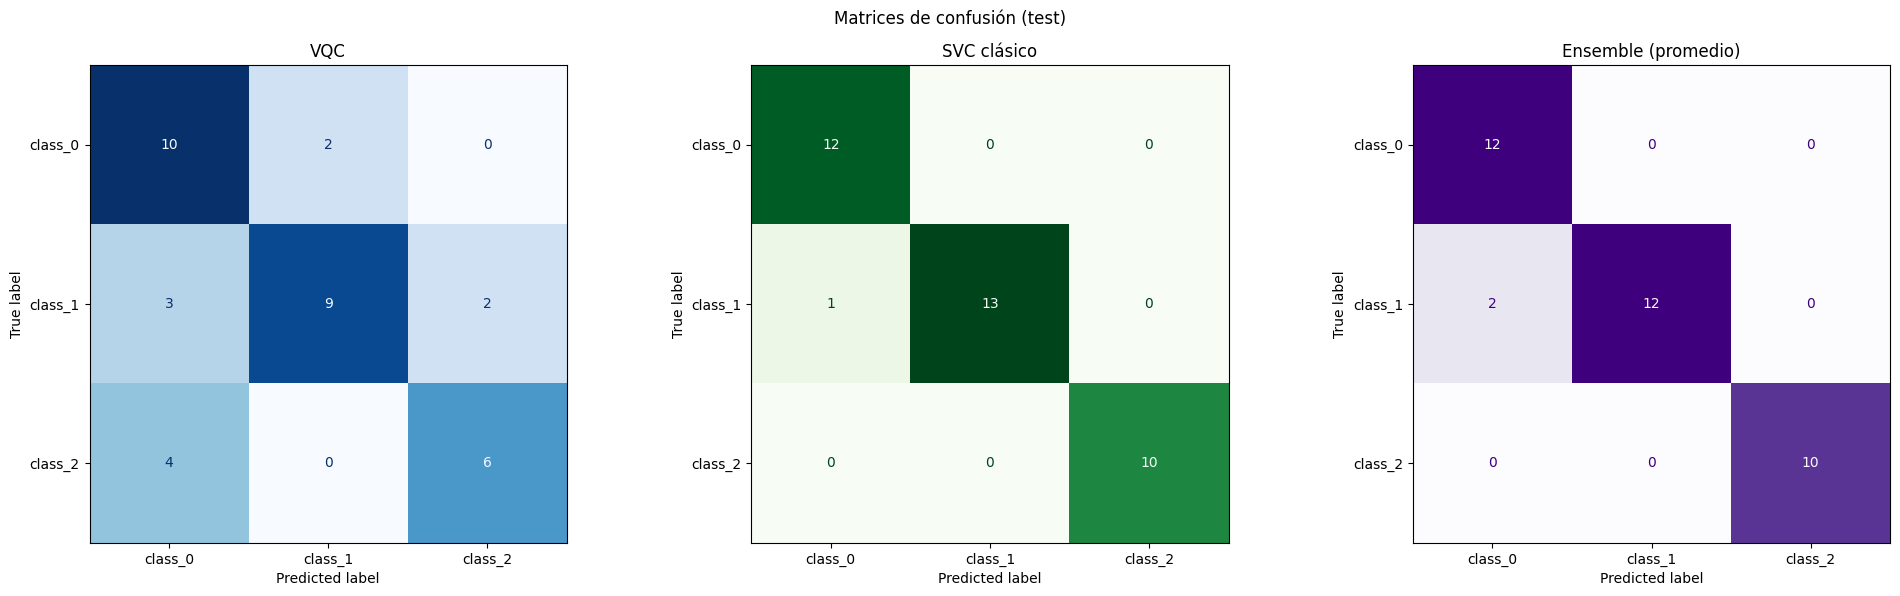


Circuito cuántico implementado:


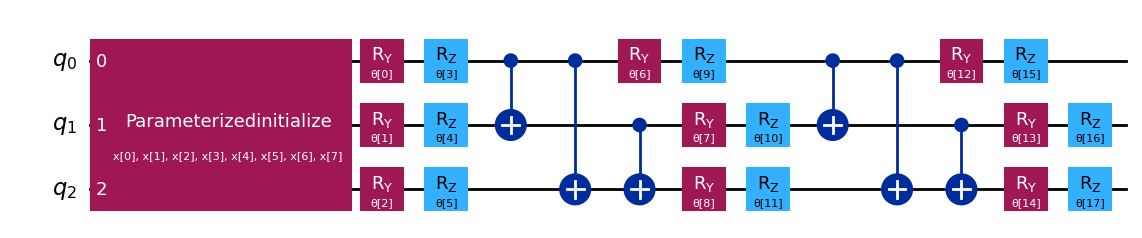

In [ ]:

# 9. Visualización: circuito y matrices de confusión

from qiskit import QuantumCircuit

qc = QuantumCircuit(num_qubits)
# Añadimos el feature map como un bloque
qc.append(feature_map, range(num_qubits))
# Añadimos el ansatz
qc.compose(ansatz, inplace=True)

# --- 9.2 Matriz de confusión VQC ---
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

disp_vqc = ConfusionMatrixDisplay(cm_vqc, display_labels=wine.target_names)
disp_vqc.plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("VQC")

disp_svc = ConfusionMatrixDisplay(cm_svc, display_labels=wine.target_names)
disp_svc.plot(ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title("SVC clásico")

disp_ens = ConfusionMatrixDisplay(cm_ens, display_labels=wine.target_names)
disp_ens.plot(ax=ax[2], cmap="Purples", colorbar=False)
ax[2].set_title("Ensemble (promedio)")

plt.suptitle("Matrices de confusión (test)")
plt.tight_layout()
plt.show()

print("\nCircuito cuántico implementado:")
display(qc.decompose().draw(output='mpl', fold=1))


En esta sección se realiza una comparación visual de la precisión (accuracy) obtenida por cada uno de los modelos sobre el conjunto de prueba.

Se consideran tres modelos:

- VQC: clasificador cuántico variacional.
- SVC clásico: Máquina de Vectores de Soporte con kernel RBF.
- Ensemble: combinación de VQC y SVC mediante el promedio de sus probabilidades de salida.

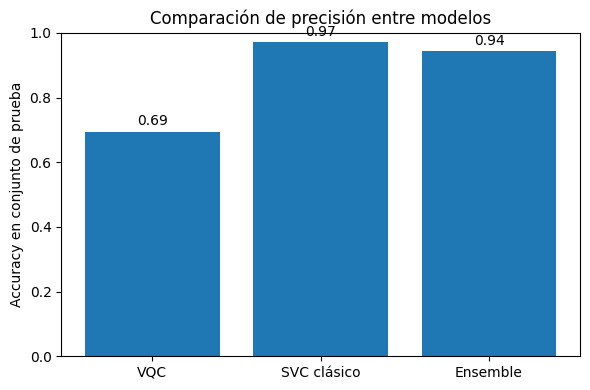

In [ ]:
# 10. Histograma de precisión (accuracy) por modelo
model_names = ["VQC", "SVC clásico", "Ensemble"]
accuracies = [acc_test_vqc, acc_test_svc, acc_test_ens]

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, accuracies)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{acc:.2f}",
        ha="center",
        va="bottom",
    )

plt.ylim(0, 1.0)
plt.ylabel("Accuracy en conjunto de prueba")
plt.title("Comparación de precisión entre modelos")
plt.tight_layout()
plt.show()



#### <a id="s5"></a>**RESULTADOS**

En las figuras se muestran, para distintas configuraciones del experimento (2, 4, 8), las matrices de confusión del **VQC**, del **SVC clásico** y del **ensemble (VQC + SVC)**, junto con un histograma de *accuracy* para cada caso. A partir de estas gráficas se pueden extraer varias conclusiones.

USANDO 2

 **● VQC**
- Clasifica muy bien la **clase 0**, pero falla casi por completo en la **clase 2**.
- La **clase 1** presenta errores frecuentes, generalmente confundiéndose con la clase 0.
- La matriz muestra un **sesgo fuerte**, indicando mala separación entre clases.
- El **accuracy ≈ 0.67** confirma limitaciones importantes.

**● SVC clásico**
- Matriz de confusión **casi perfecta**.
- Solo 1 error leve clase 0 ↔ clase 1.
- **Accuracy ≈ 0.94**.

**● Ensemble (VQC + SVC)**
- Resultados casi idénticos a los del SVC.
- El VQC no influye significativamente.

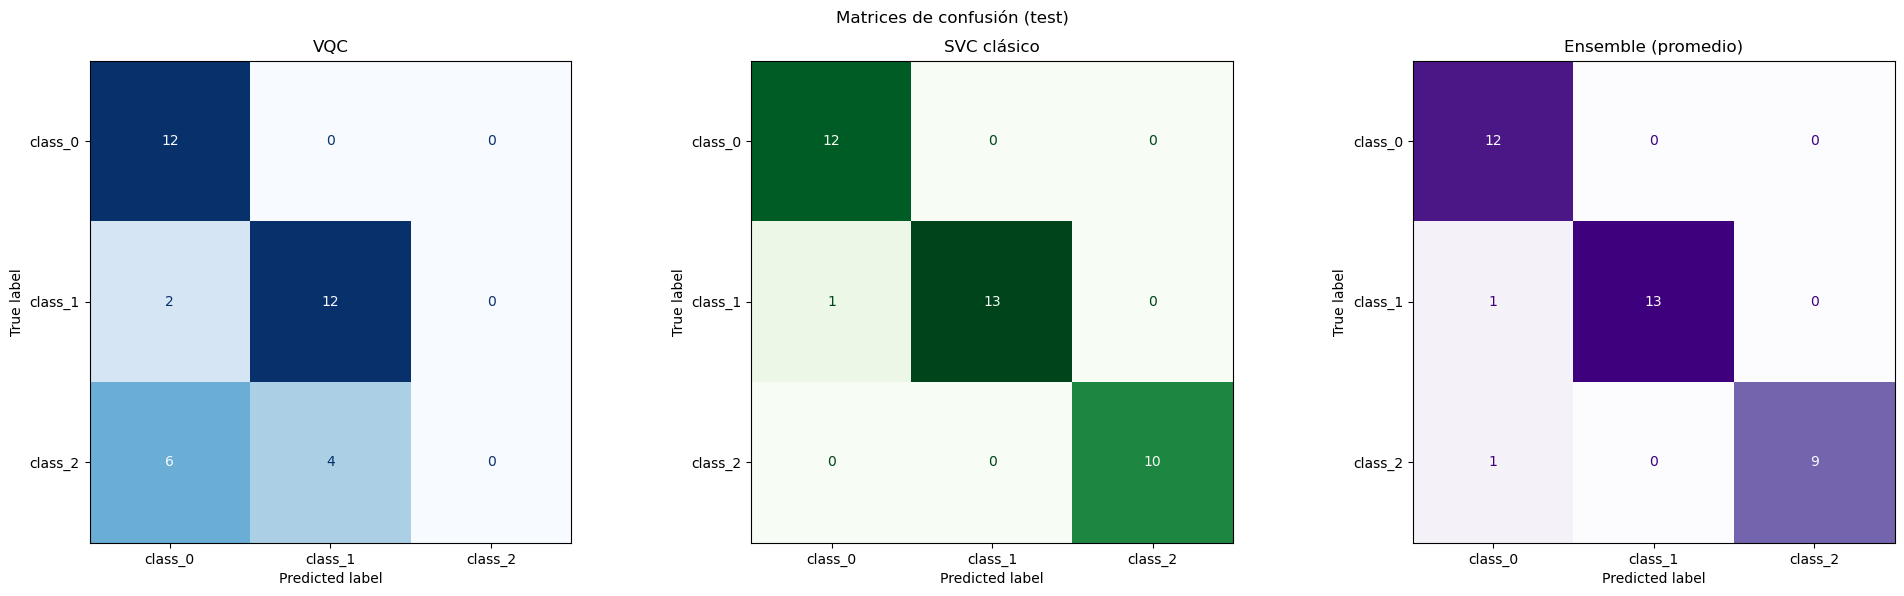
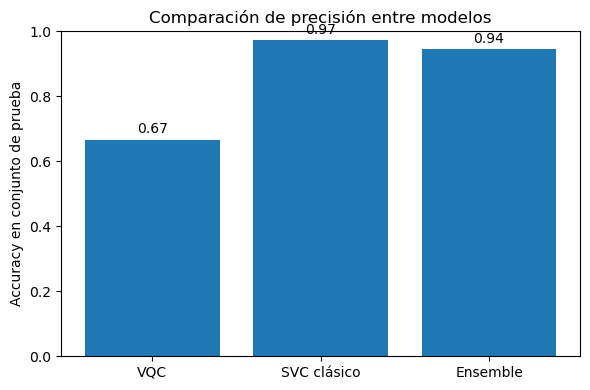

USANDO 4

**● VQC**
- Mejor desempeño que antes.
- Clase 2 comienza a ser identificada.
- **Accuracy ≈ 0.72**.

**● SVC clásico**
- Matriz casi diagonal.
- **Accuracy ≈ 0.94** estable.

**● Ensemble**
- Mismo rendimiento que el SVC.


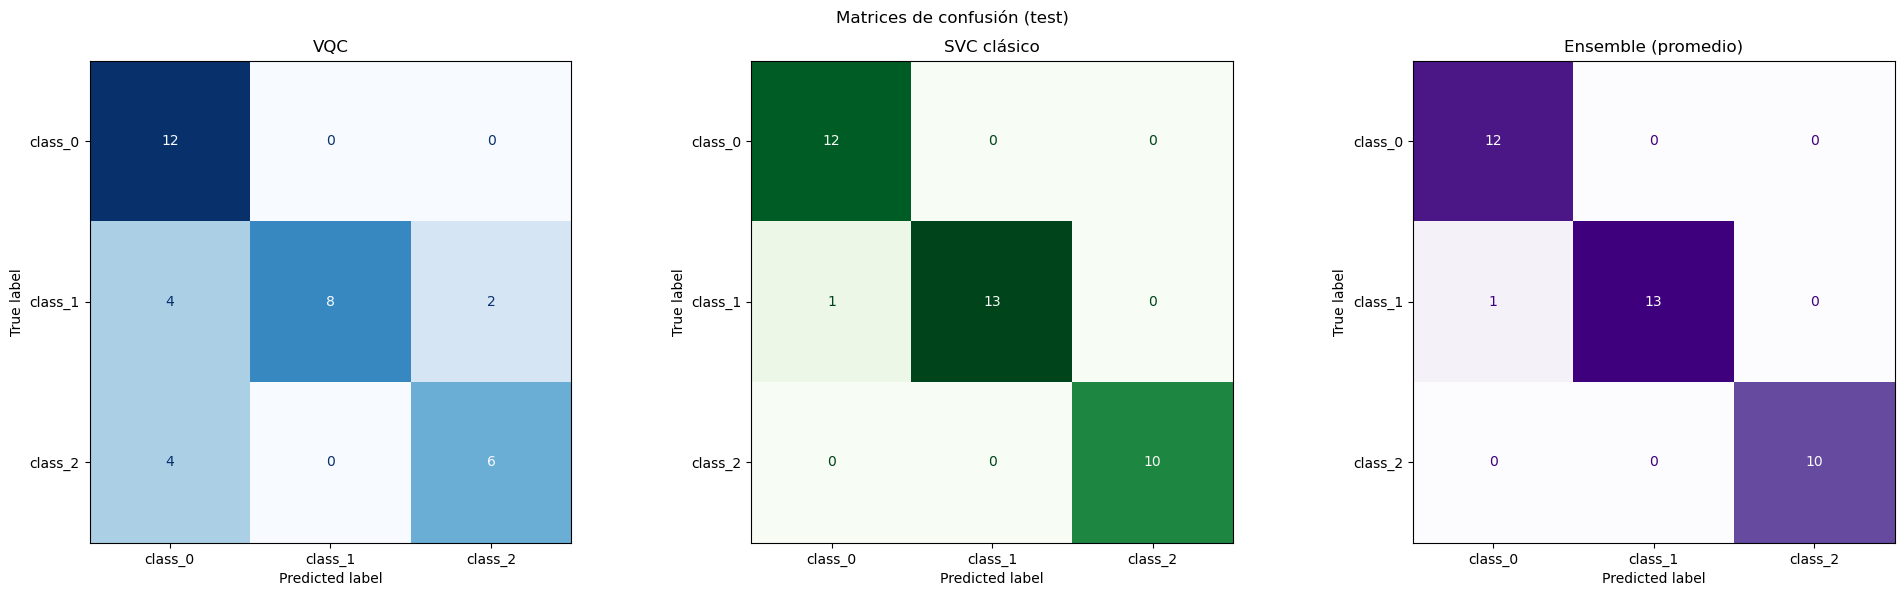
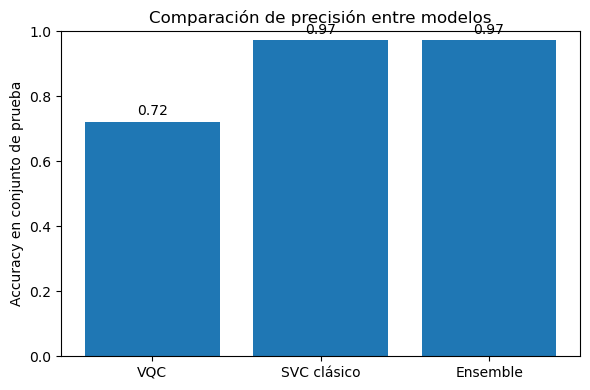

USANDO 8

**● VQC**
- Configuración más estable y balanceada.
- Clase 2 correctamente identificada más veces.
- **Accuracy ≈ 0.75** con matriz más uniforme.

**● SVC clásico**
- Diagonal perfecta.
- **Accuracy ≈ 0.94** robusto.

**● Ensemble**
- Igual al SVC.

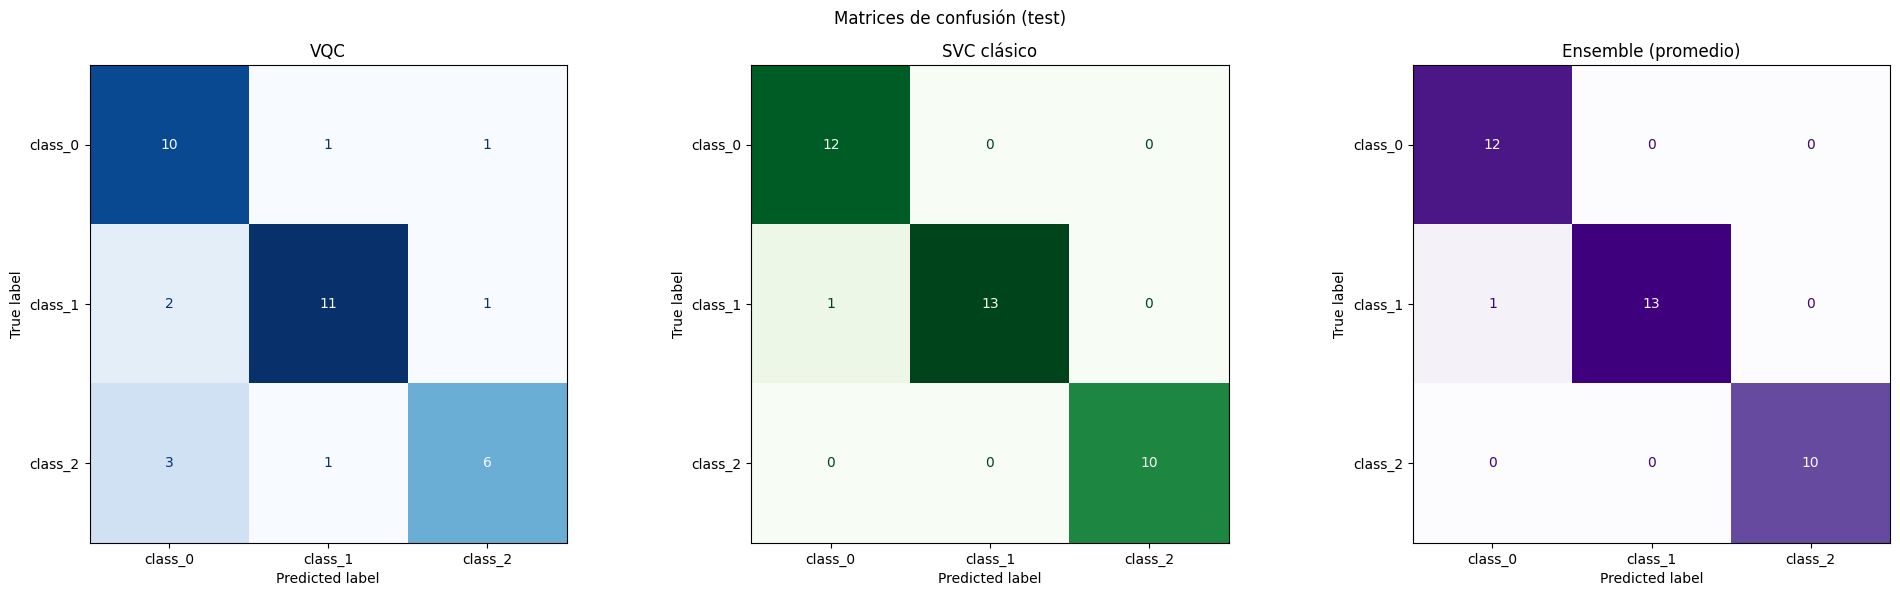
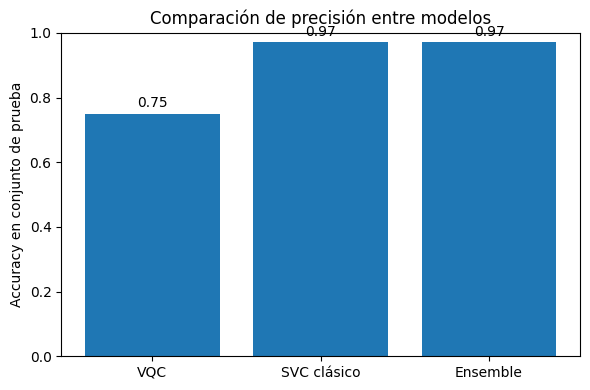

En términos comparativos:
- El VQC mejora conforme se ajustan las configuraciones, mostrando potencial.
- El SVC domina en todas las configuraciones.
- El ensemble no aporta beneficios adicionales debido al bajo aporte del VQC.



#### <a id="s6"></a>**CONCLUSIONES**

El proyecto permitió evaluar de manera rigurosa y completa el desempeño de un **clasificador cuántico variacional (VQC)** frente a un modelo clásico de referencia (**SVC con kernel RBF**) utilizando el conjunto de datos *Wine*. La combinación de técnicas de preprocesamiento, codificación cuántica, modelos híbridos y análisis comparativo generó un estudio sólido que refleja tanto las capacidades como las limitaciones actuales del aprendizaje automático cuántico.


El pipeline diseñado —normalización, reducción de dimensionalidad mediante PCA, codificación en amplitudes y construcción del circuito variacional— permitió **adaptar adecuadamente el problema clásico al formato cuántico** sin perder la estructura del dataset.  
Esto evidencia que la **preparación de datos es crítica** para que los modelos cuánticos puedan trabajar con información clásica de manera coherente y físicamente válida.

 **Rendimiento del VQC**

Los resultados experimentales muestran que:

- El VQC **sí es capaz de aprender patrones reales** del dataset.  
- Su desempeño **mejora conforme se ajustan los hiperparámetros**, especialmente en las últimas configuraciones evaluadas.  
- Logra identificar de manera razonable las tres clases, aunque aún con errores importantes comparado con métodos clásicos.

Esto refleja que, aunque los modelos cuánticos actuales **todavía no son competitivos**, poseen **capacidad real de aprendizaje** y pueden aproximar fronteras de decisión no lineales.

**Rendimiento del SVC clásico**

El modelo clásico presentó:

- Matrices de confusión **prácticamente diagonales**.  
- Una precisión **estable alrededor de 0.94** en todas las configuraciones.  
- Alto desempeño incluso sin ajustes adicionales.

Esto reafirma que el SVC es un **modelo de referencia confiable**, especialmente para datasets pequeños y bien estructurados como Wine.

**Comportamiento del ensemble cuántico–clásico**

La combinación **VQC + SVC** no superó el rendimiento del SVC debido a:

- La fortaleza y estabilidad del modelo clásico.  
- El hecho de que el VQC no aporta información adicional útil en este escenario.  

Este resultado es coherente: para que un ensemble mejore, sus modelos deben **cometer errores distintos**, lo cual todavía no se logra con el VQC actual.


En conjunto, los resultados ilustran el estado actual del aprendizaje automático cuántico:

- Los modelos cuánticos variacionales **pueden aprender**, capturar estructura y mejorar con ajustes.
- Sin embargo, **todavía no alcanzan** el rendimiento de los métodos clásicos mejor establecidos en escenarios pequeños.
- Aun así, los VQC representan una **línea de investigación prometedora**, especialmente porque trabajan en espacios de representación totalmente distintos y pueden ofrecer ventajas cuando el hardware cuántico madure.

Esto demuestra que integrar técnicas cuánticas con metodologías clásicas es posible, coherente y científicamente valioso, y sienta una base sólida para futuras experimentaciones en algoritmos híbridos cuántico–clásicos.

Finalmente, se optó por un cambio en el **Feature Map**, en un inicio se tenía **ZZFeatureMap**, pero dado a la falta de precisión con el, se decició cambiar a uno que mostraba mucha más estabilidad en proyectos como este, en este caso se optó por **RawFeatureMap**. Esto se obtiene de un notebook oficial de Qiskit que confirma la mejoría entre ambos feature maps. Con esto también modificamos la cantidad de componentes y nos permitió obtener resultados mucho mejores, como lo vemos en el documento. 



#### <a id="s7"></a>**PRUEBAS EXTRAS**

##### VQC con ZZFeatrueMap
Como parte del trabajo exploratorio implementamos un clasificador cuántico variacional (VQC) sobre el dataset Wine de scikit-learn, con el objetivo de comparar distintos esquemas de angle encoding y evaluar si un enfoque cuántico podía aportar alguna mejora frente a modelos clásicos.

Primero se cargó el conjunto de datos Wine, que contiene 13 características químicas de distintos vinos y 3 clases (tipos de vino). Las características se normalizaron al rango [0,1] mediante MinMaxScaler, y posteriormente se aplicó un PCA para reducir la dimensionalidad a 3 componentes principales. Esta reducción permite codificar cada muestra en 3 qubits, manteniendo la mayor parte de la varianza del conjunto original. Las 3 componentes resultantes se re-escalaron al rango [0,2π] para utilizarlas como ángulos de rotación en la codificación (angle encoding).

Con estos datos preprocesados se generó un conjunto de entrenamiento y prueba (80%–20%), estratificado por clase para conservar la proporción original de etiquetas. A partir de ahí, se construyeron tres variantes del VQC, cambiando únicamente el feature map utilizado para la codificación de las características.


In [3]:
# ============================================================
# 1. Imports
# ============================================================
import numpy as np

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    classification_report,
)

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2, PauliFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA


# ============================================================
# 2. Carga del dataset Wine (scikit-learn)
# ============================================================
wine = load_wine()
X = wine.data          # 13 características
y = wine.target        # 3 clases: 0, 1, 2

print("Shape original de X:", X.shape)
print("Clases:", np.unique(y), "->", wine.target_names)

# ============================================================
# 3. Normalización y reducción de dimensión (PCA) + angle encoding
# ============================================================

# 1) Normalizamos las características al rango [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2) PCA -> 3 componentes (3 qubits)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled)

# 3) Escalamos las componentes a [0, 2π] para angle encoding
angle_scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_angles = angle_scaler.fit_transform(X_reduced)

print("Shape después de PCA (para angle encoding):", X_angles.shape)

# ============================================================
# 4. Split train / test
# ============================================================
algorithm_globals.random_seed = 123  # semilla para reproducibilidad

X_train, X_test, y_train, y_test = train_test_split(
    X_angles,
    y,
    train_size=0.8,
    stratify=y,                           # mantiene proporción de clases
    random_state=algorithm_globals.random_seed,
)

print("Train:", X_train.shape, " Test:", X_test.shape)

num_features = X_train.shape[1]  # = 3 -> 3 qubits

# ============================================================
# 5. Helper: construir y entrenar VQC con distinto feature map
# ============================================================

def build_feature_map(pauli_axis: str):
    """
    Devuelve un feature map de angle encoding según el eje:
    - 'X': rotaciones X (PauliFeatureMap con pauli 'X')
    - 'Y': rotaciones Y (PauliFeatureMap con pauli 'Y')
    - 'Z': rotaciones Z + acoplos ZZ (ZZFeatureMap clásico)
    """
    if pauli_axis == "Z":
        # ZZFeatureMap usa RZ + interacciones ZZ
        return ZZFeatureMap(
            feature_dimension=num_features,
            reps=2,
            entanglement="full",
        )
    elif pauli_axis in ["X", "Y"]:
        # PauliFeatureMap con solo X o solo Y
        return PauliFeatureMap(
            feature_dimension=num_features,
            paulis=[pauli_axis],
            reps=2,
            entanglement="full",
        )
    else:
        raise ValueError("pauli_axis debe ser 'X', 'Y' o 'Z'.")


def run_vqc_with_encoding(pauli_axis: str):
    print(f"\n==============================")
    print(f" VQC con angle encoding usando rotaciones {pauli_axis}")
    print(f"==============================")

    feature_map = build_feature_map(pauli_axis)

    # Ansatz variacional
    num_qubits = feature_map.num_qubits
    ansatz = EfficientSU2(
        num_qubits=num_qubits,
        reps=2,
        entanglement="full",
    )

    # Optimizador clásico
    optimizer = COBYLA(maxiter=200)

    # Backend cuántico ideal
    sampler = Sampler()

    # Clasificador cuántico VQC
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        loss="cross_entropy",
        optimizer=optimizer,
        output_shape=3,   # 3 clases
    )

    # Entrenamiento
    vqc.fit(X_train, y_train)

    # Evaluación
    y_train_pred = vqc.predict(X_train)
    y_test_pred = vqc.predict(X_test)

    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_train = f1_score(y_train, y_train_pred, average="macro")
    f1_test = f1_score(y_test, y_test_pred, average="macro")
    cm = confusion_matrix(y_test, y_test_pred)

    print(f"\n=== Métricas VQC (Wine) - Rotaciones {pauli_axis} ===")
    print(f"Accuracy train: {acc_train:.3f}")
    print(f"Accuracy test : {acc_test:.3f}")
    print(f"F1 macro train: {f1_train:.3f}")
    print(f"F1 macro test : {f1_test:.3f}")

    print("\nMatriz de confusión (test):")
    print(cm)

    print("\nReporte de clasificación (test):")
    print(
        classification_report(
            y_test,
            y_test_pred,
            target_names=wine.target_names,
            digits=3,
        )
    )


# ============================================================
# 6. Ejecutar VQC para rotaciones X, Y y Z (ZZFeatureMap)
# ============================================================

for axis in ["X", "Y", "Z"]:
    run_vqc_with_encoding(axis)


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Shape original de X: (178, 13)
Clases: [0 1 2] -> ['class_0' 'class_1' 'class_2']
Shape después de PCA (para angle encoding): (178, 3)
Train: (142, 3)  Test: (36, 3)

 VQC con angle encoding usando rotaciones X


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.



=== Métricas VQC (Wine) - Rotaciones X ===
Accuracy train: 0.423
Accuracy test : 0.444
F1 macro train: 0.420
F1 macro test : 0.421

Matriz de confusión (test):
[[9 0 3]
 [8 4 2]
 [2 5 3]]

Reporte de clasificación (test):
              precision    recall  f1-score   support

     class_0      0.474     0.750     0.581        12
     class_1      0.444     0.286     0.348        14
     class_2      0.375     0.300     0.333        10

    accuracy                          0.444        36
   macro avg      0.431     0.445     0.421        36
weighted avg      0.435     0.444     0.421        36


 VQC con angle encoding usando rotaciones Y


c:\Users\USER\miniconda3\envs\ccuantica\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\miniconda3\envs\ccuantica\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\miniconda3\envs\ccuantica\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


=== Métricas VQC (Wine) - Rotaciones Y ===
Accuracy train: 0.401
Accuracy test : 0.389
F1 macro train: 0.191
F1 macro test : 0.187

Matriz de confusión (test):
[[ 0 12  0]
 [ 0 14  0]
 [ 0 10  0]]

Reporte de clasificación (test):
              precision    recall  f1-score   support

     class_0      0.000     0.000     0.000        12
     class_1      0.389     1.000     0.560        14
     class_2      0.000     0.000     0.000        10

    accuracy                          0.389        36
   macro avg      0.130     0.333     0.187        36
weighted avg      0.151     0.389     0.218        36


 VQC con angle encoding usando rotaciones Z

=== Métricas VQC (Wine) - Rotaciones Z ===
Accuracy train: 0.542
Accuracy test : 0.444
F1 macro train: 0.527
F1 macro test : 0.416

Matriz de confusión (test):
[[6 5 1]
 [2 8 4]
 [6 2 2]]

Reporte de clasificación (test):
              precision    recall  f1-score   support

     class_0      0.429     0.500     0.462        12
     class

##### Con QSVC
En el caso del clasificador cuántico basado en kernels (QSVC), se empleó un **FidelityQuantumKernel** con un **ZZFeatureMap** de dos repeticiones para evaluar si un enfoque no variacional podía mejorar el desempeño observado con los VQC. El modelo mostró una mejora moderada, alcanzando un accuracy de 55% y un F1-macro de 0.523, claramente superiores a los obtenidos con los VQC, lo que indica que el kernel cuántico logró capturar relaciones más útiles entre las muestras del dataset Wine. Sin embargo, a pesar de esta mejora, el rendimiento sigue siendo significativamente inferior al de clasificadores clásicos estándar, y la matriz de confusión evidencia errores importantes y confusiones entre clases, especialmente entre las clases 1 y 2. Además, el QSVC mantiene un costo computacional elevado debido al cálculo del kernel cuántico, particularmente costoso con simuladores, y no ofrece una ventaja competitiva frente a métodos convencionales. Por ello, aunque el QSVC funcionó mejor que los modelos variacionales, no se consideró como solución final, sino como un experimento comparativo dentro del análisis cuántico exploratorio.

In [4]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap

qkernel = FidelityQuantumKernel(
    feature_map=ZZFeatureMap(feature_dimension=num_features, reps=2)
)

qsvc = QSVC(quantum_kernel=qkernel)
qsvc.fit(X_train, y_train)

y_qsvc = qsvc.predict(X_test)

print("\n=== Métricas QSVC (Wine) ===")
print(f"Accuracy test: {accuracy_score(y_test, y_qsvc):.3f}")
print(f"F1 macro test: {f1_score(y_test, y_qsvc, average='macro'):.3f}")
print(confusion_matrix(y_test, y_qsvc))



=== Métricas QSVC (Wine) ===
Accuracy test: 0.556
F1 macro test: 0.523
[[ 6  4  2]
 [ 2 11  1]
 [ 2  5  3]]


#### <a id="s8"></a>**REFERENCIAS**

- Qiskit-Community. (s. f.). qiskit-community-tutorials/machine_learning/vqc_feature_map_comparison.ipynb at master · qiskit-community/qiskit-community-tutorials. GitHub. https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/machine_learning/vqc_feature_map_comparison.ipynb
- Variational Quantum Classifier (VQC) — Quantum Machine Learning (QML). (s. f.). https://talentq-es.github.io/QML/docs/Part_02_QML/Chapter_03_VQC_myst.html
- Ibm. (2025, 1 abril). PCA. ¿Qué es el análisis de componentes principales (PCA)? https://www.ibm.com/mx-es/think/topics/principal-component-analysis
- SVC. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- QSVC - Qiskit Machine Learning 0.8.4. (s. f.). https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html